In [11]:
# Get rid of warning messages and CUDA loadings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

# Import Packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io
import matplotlib.animation as animation
from matplotlib import cm
import time

In [12]:
#load data
path='data/Fisher_1D.mat'
D=1.001875195652246475e-02
r=5.011364221572875977e-01
data=scipy.io.loadmat(path)
q=500  #number of time steps
t=data['t'].flatten()[:,None]
x=data['x'].flatten()[:,None]
#create a time/space grid
X,T=np.meshgrid(x,t)
#flatten X and T
xt=np.hstack((X.flatten()[:,None],T.flatten()[:,None]))  #flatten X and T
true_u=np.real(data['u_full'])
true_u=true_u.flatten()[:,None]

In [13]:
x.shape

(201, 1)

In [14]:
np.real(data['u_full']).shape

(501, 201)

In [44]:
#define the model structure
Inputs=tf.keras.Input(shape=(1,))#1D input
layer_number=200
Dense_1=tf.keras.layers.Dense(layer_number,activation='tanh',kernel_initializer="glorot_normal")(Inputs)
Dense_2=tf.keras.layers.Dense(layer_number,activation='tanh',kernel_initializer="glorot_normal")(Dense_1)
Dense_3=tf.keras.layers.Dense(layer_number,activation='tanh',kernel_initializer="glorot_normal")(Dense_2)
Dense_4=tf.keras.layers.Dense(layer_number,activation='tanh',kernel_initializer="glorot_normal")(Dense_3)
#output layer dimension is q
Predictions=tf.keras.layers.Dense(q)(Dense_4)
model_predict=tf.keras.Model(inputs=Inputs,outputs=Predictions)

In [45]:
#parameter for initial condition
path2='data/Butcher_IRK500.txt'
IRK_weights=np.float32(np.loadtxt('data/Butcher_IRK500.txt',ndmin=2))
IRK_times = IRK_weights[q**2+q:]
IRK_weights = IRK_weights[:q**2+q].reshape((q+1,q))
IRK_alpha = tf.constant(IRK_weights[:-1,:], dtype='float32')
IRK_beta = tf.constant(IRK_weights[-1:,:], dtype='float32')

In [46]:
inputs = xt[:x.shape[0],0]  #x
# Normalize train_inputs
input_min = inputs.min(0)
input_max = inputs.max(0)
inputs_norm = 2.0*(inputs - input_min)/(input_max - input_min) - 1.0
inputs_norm  = inputs_norm.astype(np.float32)
inputs_norm = inputs_norm.reshape((inputs_norm.shape[0],1))
inputs_var = tf.Variable(inputs_norm, name='inputs_var')
dummy_x=tf.ones((inputs_var.shape[0],q),dtype=np.float32)

In [47]:
noise = 0.01
outputs_t0 = true_u[:x.shape[0],0] # Initial snapshot solution data t=0
outputs_t1 = true_u[-x.shape[0]:,0] # Final snapshot solution data t=1
train_outputs_t0_noise = outputs_t0 + noise*np.std(outputs_t0)*np.random.randn(outputs_t0.shape[0]) # Initial snapshot solution data with noise
train_outputs_t1_noise = outputs_t1 + noise*np.std(outputs_t1)*np.random.randn(outputs_t1.shape[0]) # Final snapshot solution data with noise

In [48]:
k=model_predict(inputs_var)  #initial function
#calculate the gradient
with tf.GradientTape(persistent=True) as tape:
    tape.watch(inputs_var)
    k=model_predict(inputs_var)
    u = tf.reshape(k, [x.shape[0], q])
    g_U= tape.gradient(k, inputs_var)
    g_U_x=tape.gradient(g_U,inputs_var)   
k_xx=tape.gradient(g_U_x,inputs_var)

In [49]:
scale_x = 2/(input_max-input_min)
k_x = g_U*scale_x
u_x = k_x

In [52]:
##define solution of the PDE
##dc/dt=D*d^2c/dx^2+r*c*(1-c)
class PDEsolution(tf.keras.layers.Layer):
    def __init__(self, D_var, r_var):
        super(PDEsolution, self).__init__()
        self.D_var = tf.Variable(np.array([D_var]))
        self.r_var = tf.Variable(np.array([r_var]))

    def loss(self,pred):   
        with tf.GradientTape(persistent=True) as tape:
                tape.watch(inputs_var)
                tape.watch(dummy_x)
                k = model_predict(inputs_var)
                g_U = tape.gradient(k, inputs_var, output_gradients=dummy_x)
                k_x = tape.gradient(g_U, dummy_x)
                g_U_x = tape.gradient(k_x, inputs_var, output_gradients=dummy_x)
                k_xx = tape.gradient(g_U_x, dummy_x)  
 
        scale_x = 2/(input_max-input_min) # Define scale factors and scale derivatives
        k_x = k_x*scale_x
        k_xx = k_xx*scale_x**2


        #implement the PDE
        D = tf.cast(tf.exp(self.D_var), tf.float32)
        r = tf.cast(tf.exp(self.r_var), tf.float32)
        u = k
        u_x = k_x
        u_xx = k_xx
        #change it to float32
        u_xx = tf.cast(u_xx, tf.float32)
        u= tf.cast(u, tf.float32)
        #u_t is float32 do not match the u_xx
        u_t = tf.cast(D*u_xx + r*u*(1.0-u) , tf.float32)

        # condition for the initial condition
        dt = (t[-1] - t[0])[0] #total time
        U0_pred=k-dt*tf.matmul(u_t,tf.transpose(IRK_alpha))
        U1_pred=k+dt*tf.matmul(u_t,tf.transpose(IRK_beta-IRK_alpha))
        # Format exact solutions for loss
        U0 = q*[train_outputs_t0_noise]
        U0 = tf.stack(U0, axis=1)   
        U0 = tf.cast(U0, tf.float32)
        U1 = q*[train_outputs_t1_noise]
        U1 = tf.stack(U1, axis=1)
        U1 = tf.cast(U1, tf.float32)

        # Calculate loss
        MSE = tf.reduce_mean(tf.square(U0 - U0_pred)) + tf.reduce_mean(tf.square(U1 - U1_pred))
        return MSE

    def new_method(self, k_x):
        u_x = k_x
    
    def call(self,pred):              #call the loss function
        self.add_loss(self.loss(pred))    #add loss to the model
        return pred       

In [53]:
D_guess = np.log(D)
r_guess = np.log(r)
My_loss=PDEsolution(D_guess,r_guess)(Predictions)
# Create trainable model with custom loss function

In [67]:
model_loss = tf.keras.Model(inputs=Inputs, outputs=My_loss)
model_loss.compile(optimizer=tf.keras.optimizers.Adam())
# Execute Adam optimization
Adam_Epochs=10000
inputs_var=tf.convert_to_tensor(inputs_var)
history=model_loss.fit(inputs_var,None, epochs=Adam_Epochs,verbose=0)  #None means no label

Text(0, 0.5, 'Loss')

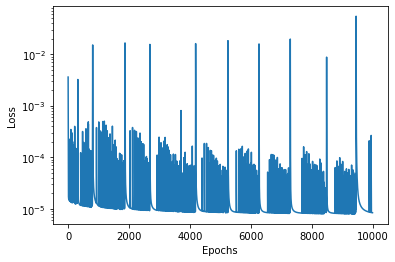

In [68]:
# Plot loss history
plt.figure()
plt.plot(history.history['loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')

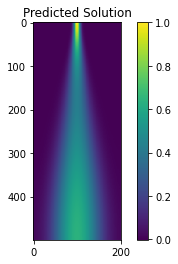

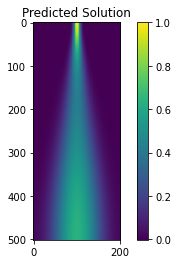

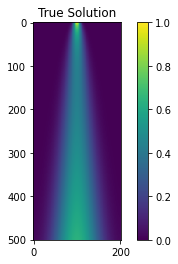

In [69]:
    # Create predicted solution
k_pred = model_predict.predict(inputs_var)
outputs_t0 = outputs_t0.reshape((outputs_t0.shape[0], 1))
outputs_t1 = outputs_t1.reshape((outputs_t1.shape[0], 1))
U_pred = np.hstack((outputs_t0, k_pred, outputs_t1)).T   #.T is the transpose of the matrix
# Plot points
plt.figure()
plt.imshow(k_pred.T, interpolation='nearest', cmap='viridis')
plt.title('Predicted Solution')
plt.colorbar()
plt.show()
#without boundary
plt.figure()
plt.imshow(U_pred, interpolation='nearest', cmap='viridis')
plt.title('Predicted Solution')
plt.colorbar()
plt.show()

# Plot true solution
u=data['u_full']

plt.figure()
plt.imshow(u, interpolation='nearest', cmap='viridis')
plt.title('True Solution')
plt.colorbar()
plt.show()

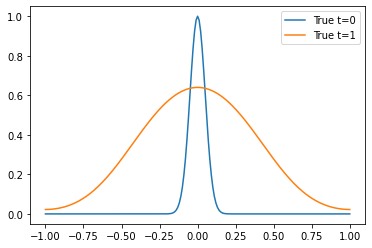

In [70]:
#plot the x-u and t-u
plt.figure()
plt.plot(x,u[0,:],label='True t=0')
plt.plot(x,u[-1,:],label='True t=1')
plt.legend()
plt.show()

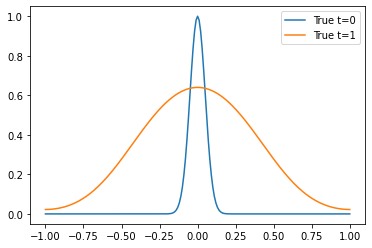

In [71]:
#plot the x-u and t-u
plt.figure()
plt.plot(x,U_pred[0,:],label='True t=0')
plt.plot(x,U_pred[-1,:],label='True t=1')
plt.legend()
plt.show()

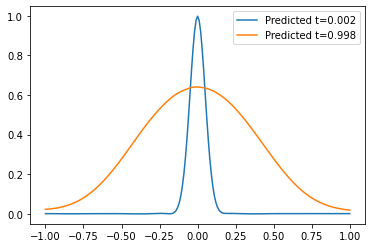

In [72]:
plt.figure()
plt.plot(x,k_pred[:,3],label='Predicted t=0.002')
plt.plot(x,k_pred[:,-3],label='Predicted t=0.998')
plt.legend()
plt.show()